In [ ]:
import cv2
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from keras import models

In [ ]:
!rm -rf sample_data
#downloading some footage
filename = 'video.mp4'
gdd.download_file_from_google_drive(file_id='1v8JhWAigsAyVFqxSh_wUJnCR8UCc81rq',
                                    dest_path=f'./{filename}')

In [ ]:
#loading the frames as a numpy array
video = cv2.VideoCapture(filename)
video.set(cv2.CAP_PROP_CONVERT_RGB, True)
frameSize = (int(video.get(4)),int(video.get(3)))
fps = video.get(cv2.CAP_PROP_FPS)
frames = []
datas = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    #the origional frames must be stored for reconstruction
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    frames.append(np.array(frame))
    #and a rescaled version too, for training
    data = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    datas.append(cv2.resize(data, (256,256))/255.0)
video.release()
print(f'frames: {len(frames)}')

frames: 164


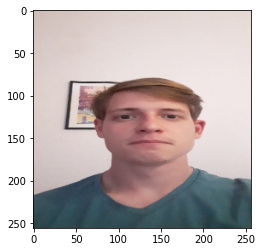

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(datas[6])

In [ ]:
#loading and using the model for prediction
model = models.load_model('trackerDeep.h5')
preds = model.predict(np.array(datas))

In [ ]:
#Exporting the frames to an other video file, with the given predictions
fourcc = cv2.VideoWriter.fourcc(*"MJPG")
out = cv2.VideoWriter('resultdeep.mp4', fourcc, fps, frameSize)
for i, frame in enumerate(frames):
  left = np.rint(preds[i][[0,1]] * frameSize).astype(int)
  right = np.rint(preds[i][[2,3]] * frameSize).astype(int)
  frame = cv2.circle(frame, tuple(left), radius=10, color=(0, 180, 255), thickness=-1)
  frame = cv2.circle(frame, tuple(right), radius=10, color=(255, 180, 0), thickness=-1)
  out.write(frame)
out.release()